In [1]:
from futuquant import *
import pandas as pd
import matplotlib
import numpy as np
import talib
%matplotlib qt

# Data Inputing

In [2]:
quote_ctx = OpenQuoteContext(host='0.0.0.0', port=11111)
HK_fututre = quote_ctx.get_history_kline('HK_FUTURE.999010', '2017-11-22', '2018-11-27', ktype=KLType.K_1M)
HK_fututre = pd.DataFrame(list(HK_fututre)[1])
quote_ctx.close()

# Data Preprocessing

In [3]:
## HSI Future DF

HK_fututre['time_key'] = (pd.to_datetime(HK_fututre['time_key'])) # Convert the time_key into datetime format
HK_fututre = HK_fututre.set_index(HK_fututre['time_key']) # Set trading hour as the index 
HK_fututre = HK_fututre.drop(['pe_ratio','turnover_rate'], axis= 1 )
normal_trading_hour = HK_fututre.between_time('09:30','16:00') #Select 09:30 - 16:00 only
#normal_trading_hour = normal_trading_hour.drop(['time_key'], axis= 1 ) #drop time_key column

In [4]:
moving_average_100 = pd.Series(talib.SMA(normal_trading_hour['close'], timeperiod=100)).values
normal_trading_hour = normal_trading_hour.assign(SMA_100 = moving_average_100)
normal_trading_hour['100_diff'] = normal_trading_hour['SMA_100'] - normal_trading_hour['close']

upper, middle, lower = talib.BBANDS(normal_trading_hour['close'], matype=talib.MA_Type.SMA, timeperiod=20)

upper = pd.Series(upper).values
normal_trading_hour = normal_trading_hour.assign(bb_upper = upper)

middle = pd.Series(middle).values
normal_trading_hour = normal_trading_hour.assign(bb_middle = middle)

lower = pd.Series(lower).values
normal_trading_hour = normal_trading_hour.assign(bb_lower = lower)

normal_trading_hour.loc['2018-04-27 13:58:00':'2018-04-27 13:59:00']

,code,time_key,open,close,high,low,volume,turnover,change_rate,last_close,SMA_100,100_diff,bb_upper,bb_middle,bb_lower
time_key,,,,,,,,,,,,,,,
2018-04-27 13:58:00,HK_FUTURE.999010,2018-04-27 13:58:00,30131.0,30134.0,30134.0,30131.0,5,150658.0,0.016595,30129.0,30105.23,-28.77,30139.476362,30134.20,30128.923638
2018-04-27 13:59:00,HK_FUTURE.999010,2018-04-27 13:59:00,30130.0,30134.0,30137.0,30130.0,4,120531.0,0.000000,30134.0,30105.50,-28.50,30139.167617,30134.05,30128.932383


# Back Testing

In [5]:
from helper.back_testing import back_testing

In [6]:
HK_future_backtesting = back_testing()
#current_inventory = HK_future_backtesting.inventory_status

In [7]:
open_upper = 5
open_lower = -5

close_upper = 5
close_lower = -5

In [8]:
HK_future_backtesting = back_testing()

#opening_order = []
cut_off_time = datetime.strptime('15:50:00', '%H:%M:%S')
cut_off_time = dt.time(cut_off_time.hour, cut_off_time.minute,  cut_off_time.second)
cut_loss_point = -50



for index, row in normal_trading_hour.iterrows():
    
    if HK_future_backtesting.current_holding() == 0: # looking for chance
        if index.time() >= cut_off_time:
            continue
            
        if (row['bb_upper'] - row['bb_lower'] > 100):
            if (row['100_diff'] > 0): # waiting for up trend change
                if open_lower <(row['close'] - row['bb_lower']) < open_upper: #long  @ lower
                    print ('%s   Long  @ %d'%(str(index),int(row['close'])))
                    
                    opening_order = HK_future_backtesting.open_position(order_time= index, position= +1, price= -int(row['close']))
                    print ('order number:', opening_order[0])
                    continue
                    
                if open_lower <(row['close'] - row['bb_middle']) < open_upper: #long  @ middle
                    print ('%s   Long  @ %d'%(str(index),int(row['close'])))
                    
                    opening_order = HK_future_backtesting.open_position(order_time= index, position= +1, price= -int(row['close']))
                    print ('order number:', opening_order[0])
                    continue

            else:  # waiting for down trend change
                
                if open_lower <(row['bb_middle'] - row['close']) < open_upper: #short  @ middle
                    print ('%s   Short  @ %d'%(str(index),int(row['close'])))
                    
                    opening_order = HK_future_backtesting.open_position(order_time= index, position= -1, price= int(row['close']))
                    print ('order number:', opening_order[0])
                    continue

                if open_lower <(row['bb_upper'] - row['close']) < open_upper: #short  @ upper
                    print ('%s   Short  @ %d'%(str(index),int(row['close'])))
                    
                    opening_order = HK_future_backtesting.open_position(order_time= index, position= -1, price= int(row['close']))
                    print ('order number:', opening_order[0])
                    continue
    
    elif HK_future_backtesting.current_holding() == 1: #having long position, finding cover
        
        #if P_L <= -cut_loss_point: #cutting loss
            
        #    close_position(order_time= index, position= -1, price= +int(row['close']), opening_order[0])
            
            
        #    continue
        
        if close_lower <(row['bb_upper'] - row['close']) < close_upper: #cover @ upper
            print ('%s   cover  @ %d'%(str(index),int(row['close'])))
            print ('order number:', opening_order[0])
            HK_future_backtesting.close_position(order_time= index, position= -1, price= +int(row['close']), order_number= opening_order[0]) ##
            
            continue
            
        if close_lower <(row['bb_middle'] - row['close']) < close_upper: #cover @ middle
            print ('%s   cover  @ %d'%(str(index),int(row['close'])))
            print ('order number:', opening_order[0])
            HK_future_backtesting.close_position(order_time= index, position= -1, price= +int(row['close']), order_number= opening_order[0]) ##

            continue
            
        if index.time() >= cut_off_time:
            HK_future_backtesting.close_position(order_time= index, position= -1, price= +int(row['close']), order_number= opening_order[0]) ##
            continue
        
        book_value = HK_future_backtesting.inventory_status(open_price=row['open'], high_price=row['high'], low_price=row['low'], close_price=row['close'])
        
        if book_value[-1] <= cut_loss_point:
            HK_future_backtesting.close_position(order_time= index, position= -1, price= +int(row['close']), order_number= opening_order[0]) ##
        
            continue
        
    elif HK_future_backtesting.current_holding() == -1: #having short call, finding cover
#         P_L = order_book[-1][1] - int(row['close'])
        
#         if P_L <= -cut_loss_point: #cutting loss
#             order_book.append([index, -int(row['close'])]) ##
#             invertory += 1
#             PL += P_L
#             continue
            
        if close_lower <(row['close'] - row['bb_middle']) < close_upper: #cover @ middle
            print ('%s   cover  @ %d'%(str(index),int(row['close'])))
            print ('order number:', opening_order[0])
            HK_future_backtesting.close_position(order_time= index, position= +1, price= -int(row['close']), order_number= opening_order[0])

            continue
            
            
        if close_lower <(row['close'] - row['bb_lower']) < close_upper: #cover @ lower
            print ('%s   cover  @ %d'%(str(index),int(row['close'])))
            print ('order number:', opening_order[0])
            HK_future_backtesting.close_position(order_time= index, position= +1, price= -int(row['close']), order_number= opening_order[0])
            
            continue
        
        if index.time() >= cut_off_time:
            HK_future_backtesting.close_position(order_time= index, position= +1, price= -int(row['close']), order_number= opening_order[0])
            
            continue
        
    
        book_value = HK_future_backtesting.inventory_status(open_price=row['open'], high_price=row['high'], low_price=row['low'], close_price=row['close'])
        
        if book_value[-1] <= cut_loss_point:
            HK_future_backtesting.close_position(order_time= index, position= +1, price= -int(row['close']), order_number= opening_order[0])
            
            continue

2018-04-03 10:14:00   Short  @ 29820
order number: 00001
Book Value @ Open: -1
Book Value @ High: -1
Book Value @ Low: 27
Book Value @ Close: 20


Book Value @ Open: 20
Book Value @ High: 12
Book Value @ Low: 42
Book Value @ Close: 16


Book Value @ Open: 16
Book Value @ High: -18
Book Value @ Low: 20
Book Value @ Close: -16


Book Value @ Open: -17
Book Value @ High: -22
Book Value @ Low: 3
Book Value @ Close: -9


Book Value @ Open: -12
Book Value @ High: -24
Book Value @ Low: 1
Book Value @ Close: -4


Book Value @ Open: -3
Book Value @ High: -24
Book Value @ Low: -3
Book Value @ Close: -23


Book Value @ Open: -23
Book Value @ High: -33
Book Value @ Low: -11
Book Value @ Close: -16


Book Value @ Open: -15
Book Value @ High: -17
Book Value @ Low: 7
Book Value @ Close: 7


Book Value @ Open: 5
Book Value @ High: -4
Book Value @ Low: 32
Book Value @ Close: 27


Book Value @ Open: 27
Book Value @ High: 20
Book Value @ Low: 34
Book Value @ Close: 32


Book Value @ Open: 33
Book Value @

2018-04-09 11:51:00   Short  @ 30426
order number: 00030
Book Value @ Open: 0
Book Value @ High: -24
Book Value @ Low: 0
Book Value @ Close: -12


Book Value @ Open: -12
Book Value @ High: -23
Book Value @ Low: -3
Book Value @ Close: -5


2018-04-09 11:54:00   cover  @ 30436
order number: 00030
-286
P and L: -10
2018-04-09 14:25:00   Long  @ 30264
order number: 00031
Book Value @ Open: -1
Book Value @ High: 18
Book Value @ Low: -5
Book Value @ Close: 11


Book Value @ Open: 11
Book Value @ High: 19
Book Value @ Low: 5
Book Value @ Close: 18


Book Value @ Open: 18
Book Value @ High: 22
Book Value @ Low: 8
Book Value @ Close: 13


2018-04-09 14:29:00   cover  @ 30270
order number: 00031
-280
P and L: 6
2018-04-09 15:01:00   Short  @ 30301
order number: 00032
Book Value @ Open: 0
Book Value @ High: -15
Book Value @ Low: 13
Book Value @ Close: 8


Book Value @ Open: 6
Book Value @ High: -10
Book Value @ Low: 20
Book Value @ Close: -2


Book Value @ Open: -3
Book Value @ High: -13
Book Val

Book Value @ High: 22
Book Value @ Low: -3
Book Value @ Close: 5


Book Value @ Open: 3
Book Value @ High: 20
Book Value @ Low: -1
Book Value @ Close: 14


Book Value @ Open: 14
Book Value @ High: 14
Book Value @ Low: -14
Book Value @ Close: -9


Book Value @ Open: -9
Book Value @ High: 13
Book Value @ Low: -9
Book Value @ Close: 5


Book Value @ Open: 8
Book Value @ High: 8
Book Value @ Low: -7
Book Value @ Close: 1


Book Value @ Open: -1
Book Value @ High: 9
Book Value @ Low: -3
Book Value @ Close: -3


Book Value @ Open: -1
Book Value @ High: 37
Book Value @ Low: -5
Book Value @ Close: 29


Book Value @ Open: 28
Book Value @ High: 29
Book Value @ Low: 17
Book Value @ Close: 24


Book Value @ Open: 25
Book Value @ High: 28
Book Value @ Low: 18
Book Value @ Close: 25


Book Value @ Open: 23
Book Value @ High: 25
Book Value @ Low: 10
Book Value @ Close: 23


Book Value @ Open: 24
Book Value @ High: 33
Book Value @ Low: 18
Book Value @ Close: 33


Book Value @ Open: 30
Book Value @ Hig

2018-04-17 09:41:00   Long  @ 30194
order number: 00072
Book Value @ Open: -1
Book Value @ High: 8
Book Value @ Low: -62
Book Value @ Close: -55


-357
P and L: -55
2018-04-17 09:43:00   Long  @ 30152
order number: 00073
Book Value @ Open: -1
Book Value @ High: 12
Book Value @ Low: -24
Book Value @ Close: 3


Book Value @ Open: 3
Book Value @ High: 20
Book Value @ Low: -5
Book Value @ Close: 11


Book Value @ Open: 10
Book Value @ High: 14
Book Value @ Low: -14
Book Value @ Close: -13


Book Value @ Open: -14
Book Value @ High: 37
Book Value @ Low: -18
Book Value @ Close: 26


Book Value @ Open: 25
Book Value @ High: 28
Book Value @ Low: -5
Book Value @ Close: 7


Book Value @ Open: 6
Book Value @ High: 17
Book Value @ Low: -6
Book Value @ Close: 8


Book Value @ Open: 7
Book Value @ High: 21
Book Value @ Low: -11
Book Value @ Close: -11


Book Value @ Open: -11
Book Value @ High: -5
Book Value @ Low: -43
Book Value @ Close: -36


Book Value @ Open: -36
Book Value @ High: -10
Book Valu


Book Value @ Open: 16
Book Value @ High: 14
Book Value @ Low: 23
Book Value @ Close: 18


Book Value @ Open: 17
Book Value @ High: 15
Book Value @ Low: 36
Book Value @ Close: 36


2018-04-19 15:38:00   cover  @ 30700
order number: 00100
-47
P and L: 32
2018-04-20 09:35:00   Long  @ 30602
order number: 00101
Book Value @ Open: -1
Book Value @ High: 8
Book Value @ Low: -27
Book Value @ Close: -9


Book Value @ Open: -10
Book Value @ High: 39
Book Value @ Low: -21
Book Value @ Close: 29


Book Value @ Open: 28
Book Value @ High: 33
Book Value @ Low: -6
Book Value @ Close: 4


Book Value @ Open: 3
Book Value @ High: 28
Book Value @ Low: 3
Book Value @ Close: 14


Book Value @ Open: 13
Book Value @ High: 20
Book Value @ Low: -1
Book Value @ Close: 15


Book Value @ Open: 16
Book Value @ High: 23
Book Value @ Low: -29
Book Value @ Close: -28


Book Value @ Open: -28
Book Value @ High: -18
Book Value @ Low: -45
Book Value @ Close: -24


Book Value @ Open: -24
Book Value @ High: -23
Book Valu

2018-04-24 10:14:00   Short  @ 30596
order number: 00117
Book Value @ Open: 0
Book Value @ High: -11
Book Value @ Low: 12
Book Value @ Close: -10


Book Value @ Open: -10
Book Value @ High: -37
Book Value @ Low: -9
Book Value @ Close: -36


Book Value @ Open: -35
Book Value @ High: -42
Book Value @ Low: -12
Book Value @ Close: -14


Book Value @ Open: -13
Book Value @ High: -23
Book Value @ Low: -10
Book Value @ Close: -16


Book Value @ Open: -16
Book Value @ High: -19
Book Value @ Low: 0
Book Value @ Close: -1


Book Value @ Open: 0
Book Value @ High: -4
Book Value @ Low: 11
Book Value @ Close: 10


Book Value @ Open: 10
Book Value @ High: -1
Book Value @ Low: 12
Book Value @ Close: 8


Book Value @ Open: 6
Book Value @ High: 1
Book Value @ Low: 20
Book Value @ Close: 9


Book Value @ Open: 7
Book Value @ High: -2
Book Value @ Low: 32
Book Value @ Close: 23


Book Value @ Open: 25
Book Value @ High: 18
Book Value @ Low: 39
Book Value @ Close: 38


Book Value @ Open: 40
Book Value @ H

Book Value @ High: -16
Book Value @ Low: 1
Book Value @ Close: -6


Book Value @ Open: -6
Book Value @ High: -30
Book Value @ Low: -6
Book Value @ Close: -24


Book Value @ Open: -27
Book Value @ High: -57
Book Value @ Low: -27
Book Value @ Close: -42


Book Value @ Open: -42
Book Value @ High: -60
Book Value @ Low: -32
Book Value @ Close: -49


Book Value @ Open: -49
Book Value @ High: -65
Book Value @ Low: -44
Book Value @ Close: -58


-286
P and L: -58
2018-04-27 10:07:00   Short  @ 30128
order number: 00129
2018-04-27 10:08:00   cover  @ 30133
order number: 00129
-291
P and L: -5
2018-05-02 09:33:00   Long  @ 30551
order number: 00130
Book Value @ Open: 0
Book Value @ High: 5
Book Value @ Low: -24
Book Value @ Close: -13


Book Value @ Open: -12
Book Value @ High: -11
Book Value @ Low: -60
Book Value @ Close: -52


-343
P and L: -52
2018-05-02 09:36:00   Long  @ 30491
order number: 00131
Book Value @ Open: 0
Book Value @ High: 18
Book Value @ Low: -13
Book Value @ Close: 12


Book 

Book Value @ Open: 98
Book Value @ High: 106
Book Value @ Low: 80
Book Value @ Close: 94


Book Value @ Open: 94
Book Value @ High: 125
Book Value @ Low: 87
Book Value @ Close: 90


2018-05-04 09:42:00   cover  @ 30115
order number: 00138
-311
P and L: 71
2018-05-04 10:12:00   Long  @ 29839
order number: 00139
Book Value @ Open: 1
Book Value @ High: 23
Book Value @ Low: -13
Book Value @ Close: 17


Book Value @ Open: 17
Book Value @ High: 30
Book Value @ Low: 4
Book Value @ Close: 15


Book Value @ Open: 15
Book Value @ High: 17
Book Value @ Low: -8
Book Value @ Close: 10


2018-05-04 10:16:00   cover  @ 29829
order number: 00139
-321
P and L: -10
2018-05-04 11:11:00   Short  @ 29944
order number: 00140
Book Value @ Open: 0
Book Value @ High: 0
Book Value @ Low: 26
Book Value @ Close: 26


Book Value @ Open: 26
Book Value @ High: 8
Book Value @ Low: 30
Book Value @ Close: 14


Book Value @ Open: 16
Book Value @ High: -3
Book Value @ Low: 31
Book Value @ Close: 1


Book Value @ Open: 2


Book Value @ Open: 53
Book Value @ High: 35
Book Value @ Low: 59
Book Value @ Close: 45


Book Value @ Open: 46
Book Value @ High: 3
Book Value @ Low: 55
Book Value @ Close: 21


Book Value @ Open: 21
Book Value @ High: 15
Book Value @ Low: 44
Book Value @ Close: 28


Book Value @ Open: 27
Book Value @ High: 15
Book Value @ Low: 46
Book Value @ Close: 29


Book Value @ Open: 29
Book Value @ High: 5
Book Value @ Low: 38
Book Value @ Close: 32


Book Value @ Open: 31
Book Value @ High: 31
Book Value @ Low: 51
Book Value @ Close: 46


Book Value @ Open: 46
Book Value @ High: 38
Book Value @ Low: 64
Book Value @ Close: 45


Book Value @ Open: 44
Book Value @ High: 22
Book Value @ Low: 54
Book Value @ Close: 46


Book Value @ Open: 45
Book Value @ High: 32
Book Value @ Low: 53
Book Value @ Close: 53


Book Value @ Open: 51
Book Value @ High: 33
Book Value @ Low: 54
Book Value @ Close: 41


2018-05-11 09:47:00   cover  @ 30889
order number: 00161
-130
P and L: 44
2018-05-11 09:55:00   Short 

Book Value @ High: 14
Book Value @ Low: -10
Book Value @ Close: 11


Book Value @ Open: 12
Book Value @ High: 27
Book Value @ Low: 6
Book Value @ Close: 21


Book Value @ Open: 20
Book Value @ High: 24
Book Value @ Low: 9
Book Value @ Close: 21


Book Value @ Open: 18
Book Value @ High: 22
Book Value @ Low: 9
Book Value @ Close: 9


Book Value @ Open: 10
Book Value @ High: 17
Book Value @ Low: 8
Book Value @ Close: 12


Book Value @ Open: 14
Book Value @ High: 19
Book Value @ Low: 3
Book Value @ Close: 14


Book Value @ Open: 13
Book Value @ High: 16
Book Value @ Low: 7
Book Value @ Close: 9


Book Value @ Open: 8
Book Value @ High: 24
Book Value @ Low: 1
Book Value @ Close: 20


Book Value @ Open: 20
Book Value @ High: 26
Book Value @ Low: 16
Book Value @ Close: 21


Book Value @ Open: 20
Book Value @ High: 23
Book Value @ Low: 1
Book Value @ Close: 3


Book Value @ Open: 2
Book Value @ High: 13
Book Value @ Low: -3
Book Value @ Close: 6


Book Value @ Open: 5
Book Value @ High: 13
Bo

Book Value @ High: -15
Book Value @ Low: -46
Book Value @ Close: -46


2018-05-25 09:57:00   cover  @ 30637
order number: 00197
-114
P and L: -21
2018-05-25 11:25:00   Short  @ 30679
order number: 00198
Book Value @ Open: 0
Book Value @ High: -11
Book Value @ Low: 7
Book Value @ Close: 1


Book Value @ Open: 3
Book Value @ High: -7
Book Value @ Low: 9
Book Value @ Close: 1


Book Value @ Open: 0
Book Value @ High: -9
Book Value @ Low: 6
Book Value @ Close: -2


Book Value @ Open: -1
Book Value @ High: -6
Book Value @ Low: 3
Book Value @ Close: 1


Book Value @ Open: 2
Book Value @ High: -25
Book Value @ Low: 3
Book Value @ Close: -22


Book Value @ Open: -22
Book Value @ High: -37
Book Value @ Low: -12
Book Value @ Close: -35


Book Value @ Open: -34
Book Value @ High: -51
Book Value @ Low: -34
Book Value @ Close: -38


Book Value @ Open: -40
Book Value @ High: -43
Book Value @ Low: -29
Book Value @ Close: -36


Book Value @ Open: -35
Book Value @ High: -37
Book Value @ Low: -18
Book V

Book Value @ Low: -3
Book Value @ Close: -7


Book Value @ Open: -5
Book Value @ High: -21
Book Value @ Low: -5
Book Value @ Close: -18


Book Value @ Open: -20
Book Value @ High: -23
Book Value @ Low: -9
Book Value @ Close: -10


Book Value @ Open: -11
Book Value @ High: -15
Book Value @ Low: 13
Book Value @ Close: 9


Book Value @ Open: 9
Book Value @ High: 9
Book Value @ Low: 28
Book Value @ Close: 23


Book Value @ Open: 21
Book Value @ High: 17
Book Value @ Low: 24
Book Value @ Close: 24


Book Value @ Open: 25
Book Value @ High: 11
Book Value @ Low: 28
Book Value @ Close: 11


Book Value @ Open: 11
Book Value @ High: -2
Book Value @ Low: 13
Book Value @ Close: 5


Book Value @ Open: 4
Book Value @ High: -11
Book Value @ Low: 7
Book Value @ Close: 6


Book Value @ Open: 6
Book Value @ High: 6
Book Value @ Low: 23
Book Value @ Close: 21


Book Value @ Open: 21
Book Value @ High: 13
Book Value @ Low: 23
Book Value @ Close: 14


Book Value @ Open: 14
Book Value @ High: 14
Book Value 

P and L: 31
2018-06-12 09:49:00   Short  @ 31136
order number: 00234
Book Value @ Open: -2
Book Value @ High: -17
Book Value @ Low: 6
Book Value @ Close: -16


Book Value @ Open: -16
Book Value @ High: -20
Book Value @ Low: 4
Book Value @ Close: 3


Book Value @ Open: 3
Book Value @ High: -6
Book Value @ Low: 5
Book Value @ Close: -6


Book Value @ Open: -6
Book Value @ High: -52
Book Value @ Low: -5
Book Value @ Close: -34


Book Value @ Open: -36
Book Value @ High: -57
Book Value @ Low: -34
Book Value @ Close: -49


Book Value @ Open: -51
Book Value @ High: -101
Book Value @ Low: -49
Book Value @ Close: -72


-47
P and L: -72
2018-06-12 09:56:00   Short  @ 31218
order number: 00235
Book Value @ Open: 0
Book Value @ High: 0
Book Value @ Low: 28
Book Value @ Close: 26


Book Value @ Open: 26
Book Value @ High: 22
Book Value @ Low: 35
Book Value @ Close: 35


Book Value @ Open: 34
Book Value @ High: 13
Book Value @ Low: 38
Book Value @ Close: 18


Book Value @ Open: 17
Book Value @ High

2018-06-19 14:03:00   Long  @ 29456
order number: 00252
Book Value @ Open: 1
Book Value @ High: 1
Book Value @ Low: -35
Book Value @ Close: -15


Book Value @ Open: -15
Book Value @ High: -13
Book Value @ Low: -30
Book Value @ Close: -24


Book Value @ Open: -24
Book Value @ High: -24
Book Value @ Low: -52
Book Value @ Close: -36


Book Value @ Open: -37
Book Value @ High: -31
Book Value @ Low: -48
Book Value @ Close: -35


Book Value @ Open: -35
Book Value @ High: -30
Book Value @ Low: -44
Book Value @ Close: -33


Book Value @ Open: -32
Book Value @ High: -11
Book Value @ Low: -34
Book Value @ Close: -15


Book Value @ Open: -16
Book Value @ High: -16
Book Value @ Low: -44
Book Value @ Close: -41


Book Value @ Open: -39
Book Value @ High: -31
Book Value @ Low: -45
Book Value @ Close: -39


Book Value @ Open: -41
Book Value @ High: -36
Book Value @ Low: -56
Book Value @ Close: -50


-47
P and L: -50
2018-06-19 14:18:00   Long  @ 29438
order number: 00253
2018-06-19 14:19:00   cover  

Book Value @ Open: 13
Book Value @ High: -6
Book Value @ Low: 15
Book Value @ Close: 13


Book Value @ Open: 12
Book Value @ High: 4
Book Value @ Low: 25
Book Value @ Close: 6


Book Value @ Open: 7
Book Value @ High: -36
Book Value @ Low: 7
Book Value @ Close: -34


Book Value @ Open: -37
Book Value @ High: -52
Book Value @ Low: -7
Book Value @ Close: -17


Book Value @ Open: -15
Book Value @ High: -18
Book Value @ Low: -6
Book Value @ Close: -8


Book Value @ Open: -8
Book Value @ High: -10
Book Value @ Low: 11
Book Value @ Close: 8


Book Value @ Open: 8
Book Value @ High: -14
Book Value @ Low: 9
Book Value @ Close: -3


Book Value @ Open: -5
Book Value @ High: -15
Book Value @ Low: 8
Book Value @ Close: 6


2018-06-22 11:16:00   cover  @ 29234
order number: 00280
-235
P and L: 22
2018-06-22 11:39:00   Long  @ 29170
order number: 00281
Book Value @ Open: -2
Book Value @ High: 0
Book Value @ Low: -17
Book Value @ Close: -13


Book Value @ Open: -12
Book Value @ High: -9
Book Value @ 


-369
P and L: -78
2018-06-27 10:07:00   Long  @ 28760
order number: 00313
Book Value @ Open: -1
Book Value @ High: 0
Book Value @ Low: -23
Book Value @ Close: -15


Book Value @ Open: -15
Book Value @ High: -15
Book Value @ Low: -37
Book Value @ Close: -29


Book Value @ Open: -28
Book Value @ High: -23
Book Value @ Low: -41
Book Value @ Close: -23


Book Value @ Open: -24
Book Value @ High: 0
Book Value @ Low: -36
Book Value @ Close: -2


Book Value @ Open: -2
Book Value @ High: 23
Book Value @ Low: -19
Book Value @ Close: 22


Book Value @ Open: 21
Book Value @ High: 23
Book Value @ Low: -7
Book Value @ Close: -5


Book Value @ Open: -7
Book Value @ High: 19
Book Value @ Low: -8
Book Value @ Close: 16


Book Value @ Open: 12
Book Value @ High: 17
Book Value @ Low: -16
Book Value @ Close: -7


Book Value @ Open: -7
Book Value @ High: 11
Book Value @ Low: -9
Book Value @ Close: 4


2018-06-27 10:17:00   cover  @ 28798
order number: 00313
-331
P and L: 38
2018-06-27 10:26:00   Short  @

2018-06-29 13:37:00   Long  @ 28613
order number: 00335
Book Value @ Open: 0
Book Value @ High: 4
Book Value @ Low: -22
Book Value @ Close: 4


Book Value @ Open: 4
Book Value @ High: 19
Book Value @ Low: 2
Book Value @ Close: 14


Book Value @ Open: 15
Book Value @ High: 15
Book Value @ Low: 0
Book Value @ Close: 6


Book Value @ Open: 8
Book Value @ High: 28
Book Value @ Low: 4
Book Value @ Close: 18


Book Value @ Open: 19
Book Value @ High: 39
Book Value @ Low: 19
Book Value @ Close: 34


Book Value @ Open: 32
Book Value @ High: 50
Book Value @ Low: 17
Book Value @ Close: 23


Book Value @ Open: 24
Book Value @ High: 25
Book Value @ Low: 3
Book Value @ Close: 14


Book Value @ Open: 15
Book Value @ High: 23
Book Value @ Low: 8
Book Value @ Close: 20


2018-06-29 13:46:00   cover  @ 28653
order number: 00335
-129
P and L: 40
2018-06-29 13:47:00   Short  @ 28648
order number: 00336
Book Value @ Open: -1
Book Value @ High: -24
Book Value @ Low: -1
Book Value @ Close: -11


Book Value 


Book Value @ Open: 3
Book Value @ High: -11
Book Value @ Low: 11
Book Value @ Close: 2


Book Value @ Open: 4
Book Value @ High: -1
Book Value @ Low: 11
Book Value @ Close: 5


2018-07-05 10:48:00   cover  @ 28176
order number: 00371
-705
P and L: 27
2018-07-05 11:03:00   Long  @ 28108
order number: 00372
Book Value @ Open: -2
Book Value @ High: -1
Book Value @ Low: -26
Book Value @ Close: -12


Book Value @ Open: -14
Book Value @ High: -2
Book Value @ Low: -27
Book Value @ Close: -16


Book Value @ Open: -18
Book Value @ High: 0
Book Value @ Low: -28
Book Value @ Close: -8


Book Value @ Open: -11
Book Value @ High: 0
Book Value @ Low: -26
Book Value @ Close: -6


Book Value @ Open: -6
Book Value @ High: 7
Book Value @ Low: -14
Book Value @ Close: -14


Book Value @ Open: -12
Book Value @ High: 7
Book Value @ Low: -14
Book Value @ Close: -1


Book Value @ Open: -3
Book Value @ High: 2
Book Value @ Low: -20
Book Value @ Close: -8


Book Value @ Open: -6
Book Value @ High: 0
Book Value

Book Value @ Open: 18
Book Value @ High: 11
Book Value @ Low: 24
Book Value @ Close: 24


Book Value @ Open: 22
Book Value @ High: 19
Book Value @ Low: 30
Book Value @ Close: 24


Book Value @ Open: 23
Book Value @ High: 21
Book Value @ Low: 30
Book Value @ Close: 23


Book Value @ Open: 25
Book Value @ High: 6
Book Value @ Low: 26
Book Value @ Close: 16


2018-07-10 11:40:00   cover  @ 28855
order number: 00397
-337
P and L: 25
2018-07-10 14:36:00   Short  @ 28792
order number: 00398
Book Value @ Open: -1
Book Value @ High: -5
Book Value @ Low: 9
Book Value @ Close: 0


Book Value @ Open: 0
Book Value @ High: -23
Book Value @ Low: 1
Book Value @ Close: -21


Book Value @ Open: -21
Book Value @ High: -30
Book Value @ Low: -12
Book Value @ Close: -17


Book Value @ Open: -18
Book Value @ High: -26
Book Value @ Low: -14
Book Value @ Close: -17


Book Value @ Open: -17
Book Value @ High: -34
Book Value @ Low: -13
Book Value @ Close: -32


Book Value @ Open: -32
Book Value @ High: -57
Book

Book Value @ High: 51
Book Value @ Low: -1
Book Value @ Close: 45


Book Value @ Open: 45
Book Value @ High: 64
Book Value @ Low: 36
Book Value @ Close: 39


2018-07-16 10:05:00   cover  @ 28449
order number: 00413
-279
P and L: 18
2018-07-16 10:33:00   Long  @ 28332
order number: 00414
Book Value @ Open: 3
Book Value @ High: 13
Book Value @ Low: -4
Book Value @ Close: 6


Book Value @ Open: 5
Book Value @ High: 5
Book Value @ Low: -8
Book Value @ Close: 5


Book Value @ Open: 5
Book Value @ High: 8
Book Value @ Low: -13
Book Value @ Close: 6


Book Value @ Open: 7
Book Value @ High: 28
Book Value @ Low: 4
Book Value @ Close: 14


Book Value @ Open: 13
Book Value @ High: 29
Book Value @ Low: 10
Book Value @ Close: 25


Book Value @ Open: 26
Book Value @ High: 34
Book Value @ Low: 4
Book Value @ Close: 5


Book Value @ Open: 5
Book Value @ High: 42
Book Value @ Low: 5
Book Value @ Close: 30


Book Value @ Open: 31
Book Value @ High: 35
Book Value @ Low: 9
Book Value @ Close: 19


Book V

2018-07-20 15:42:00   Short  @ 28287
order number: 00435
Book Value @ Open: 0
Book Value @ High: -6
Book Value @ Low: 17
Book Value @ Close: 4


Book Value @ Open: 5
Book Value @ High: -9
Book Value @ Low: 7
Book Value @ Close: -6


Book Value @ Open: -8
Book Value @ High: -10
Book Value @ Low: 16
Book Value @ Close: 13


Book Value @ Open: 14
Book Value @ High: 1
Book Value @ Low: 14
Book Value @ Close: 4


Book Value @ Open: 3
Book Value @ High: 2
Book Value @ Low: 30
Book Value @ Close: 25


Book Value @ Open: 25
Book Value @ High: 24
Book Value @ Low: 33
Book Value @ Close: 32


Book Value @ Open: 30
Book Value @ High: 18
Book Value @ Low: 32
Book Value @ Close: 18


2018-07-20 15:50:00   cover  @ 28250
order number: 00435
-206
P and L: 37
2018-07-23 09:31:00   Short  @ 28305
order number: 00436
Book Value @ Open: 2
Book Value @ High: -59
Book Value @ Low: 23
Book Value @ Close: -10


Book Value @ Open: -13
Book Value @ High: -77
Book Value @ Low: 6
Book Value @ Close: -64


-270
P

order number: 00465
Book Value @ Open: -1
Book Value @ High: -12
Book Value @ Low: 6
Book Value @ Close: -7


Book Value @ Open: -8
Book Value @ High: -11
Book Value @ Low: 3
Book Value @ Close: 3


Book Value @ Open: 3
Book Value @ High: -2
Book Value @ Low: 10
Book Value @ Close: 6


Book Value @ Open: 7
Book Value @ High: 4
Book Value @ Low: 18
Book Value @ Close: 12


Book Value @ Open: 12
Book Value @ High: 11
Book Value @ Low: 19
Book Value @ Close: 15


Book Value @ Open: 13
Book Value @ High: -7
Book Value @ Low: 14
Book Value @ Close: -3


Book Value @ Open: -2
Book Value @ High: -10
Book Value @ Low: 3
Book Value @ Close: -4


2018-07-31 11:02:00   cover  @ 28611
order number: 00465
133
P and L: -7
2018-07-31 13:44:00   Short  @ 28620
order number: 00466
Book Value @ Open: -1
Book Value @ High: -17
Book Value @ Low: 0
Book Value @ Close: -10


Book Value @ Open: -8
Book Value @ High: -19
Book Value @ Low: 2
Book Value @ Close: -15


Book Value @ Open: -14
Book Value @ High: -

Book Value @ Open: 7
Book Value @ High: 0
Book Value @ Low: 10
Book Value @ Close: 10


Book Value @ Open: 8
Book Value @ High: 2
Book Value @ Low: 10
Book Value @ Close: 3


Book Value @ Open: 4
Book Value @ High: 0
Book Value @ Low: 15
Book Value @ Close: 12


Book Value @ Open: 12
Book Value @ High: 10
Book Value @ Low: 37
Book Value @ Close: 23


Book Value @ Open: 23
Book Value @ High: 21
Book Value @ Low: 29
Book Value @ Close: 26


Book Value @ Open: 25
Book Value @ High: 22
Book Value @ Low: 30
Book Value @ Close: 26


Book Value @ Open: 25
Book Value @ High: 11
Book Value @ Low: 26
Book Value @ Close: 18


Book Value @ Open: 18
Book Value @ High: 16
Book Value @ Low: 28
Book Value @ Close: 20


Book Value @ Open: 19
Book Value @ High: 15
Book Value @ Low: 25
Book Value @ Close: 19


Book Value @ Open: 19
Book Value @ High: 5
Book Value @ Low: 19
Book Value @ Close: 10


2018-08-03 11:40:00   cover  @ 27646
order number: 00490
152
P and L: 7
2018-08-03 13:25:00   Short  @ 27630

235
P and L: 54
2018-08-09 09:56:00   Long  @ 28218
order number: 00508
Book Value @ Open: 0
Book Value @ High: 22
Book Value @ Low: -2
Book Value @ Close: 17


2018-08-09 09:58:00   cover  @ 28226
order number: 00508
243
P and L: 8
2018-08-09 10:28:00   Short  @ 28365
order number: 00509
Book Value @ Open: 0
Book Value @ High: -34
Book Value @ Low: 5
Book Value @ Close: -7


Book Value @ Open: -9
Book Value @ High: -9
Book Value @ Low: 24
Book Value @ Close: 17


Book Value @ Open: 17
Book Value @ High: 0
Book Value @ Low: 29
Book Value @ Close: 25


Book Value @ Open: 23
Book Value @ High: 11
Book Value @ Low: 26
Book Value @ Close: 19


Book Value @ Open: 19
Book Value @ High: -3
Book Value @ Low: 19
Book Value @ Close: 4


Book Value @ Open: 4
Book Value @ High: -2
Book Value @ Low: 11
Book Value @ Close: 2


Book Value @ Open: 0
Book Value @ High: -55
Book Value @ Low: 1
Book Value @ Close: -53


190
P and L: -53
2018-08-09 10:57:00   Short  @ 28497
order number: 00510
Book Value 

129
P and L: -6
2018-08-14 13:44:00   Long  @ 27467
order number: 00526
Book Value @ Open: 0
Book Value @ High: 4
Book Value @ Low: -21
Book Value @ Close: -12


Book Value @ Open: -13
Book Value @ High: -4
Book Value @ Low: -23
Book Value @ Close: -5


Book Value @ Open: -5
Book Value @ High: 12
Book Value @ Low: -7
Book Value @ Close: 4


Book Value @ Open: 4
Book Value @ High: 23
Book Value @ Low: 0
Book Value @ Close: 21


Book Value @ Open: 22
Book Value @ High: 25
Book Value @ Low: 9
Book Value @ Close: 12


Book Value @ Open: 12
Book Value @ High: 14
Book Value @ Low: 4
Book Value @ Close: 13


Book Value @ Open: 14
Book Value @ High: 55
Book Value @ Low: 13
Book Value @ Close: 51


Book Value @ Open: 51
Book Value @ High: 85
Book Value @ Low: 43
Book Value @ Close: 81


Book Value @ Open: 81
Book Value @ High: 89
Book Value @ Low: 65
Book Value @ Close: 68


Book Value @ Open: 70
Book Value @ High: 79
Book Value @ Low: 66
Book Value @ Close: 70


Book Value @ Open: 70
Book Valu

2018-08-17 10:09:00   cover  @ 27215
order number: 00547
262
P and L: 7
2018-08-17 10:54:00   Long  @ 27135
order number: 00548
Book Value @ Open: 1
Book Value @ High: 12
Book Value @ Low: 1
Book Value @ Close: 8


2018-08-17 10:56:00   cover  @ 27131
order number: 00548
258
P and L: -4
2018-08-17 14:26:00   Long  @ 27076
order number: 00549
Book Value @ Open: -1
Book Value @ High: 14
Book Value @ Low: -8
Book Value @ Close: 1


Book Value @ Open: 1
Book Value @ High: 16
Book Value @ Low: 0
Book Value @ Close: 11


Book Value @ Open: 11
Book Value @ High: 18
Book Value @ Low: 8
Book Value @ Close: 11


Book Value @ Open: 11
Book Value @ High: 12
Book Value @ Low: -21
Book Value @ Close: -10


Book Value @ Open: -10
Book Value @ High: 29
Book Value @ Low: -13
Book Value @ Close: 17


Book Value @ Open: 17
Book Value @ High: 17
Book Value @ Low: -2
Book Value @ Close: -2


Book Value @ Open: -2
Book Value @ High: 9
Book Value @ Low: -28
Book Value @ Close: -24


Book Value @ Open: -24
Bo

Book Value @ Close: -8


Book Value @ Open: -7
Book Value @ High: 9
Book Value @ Low: -10
Book Value @ Close: -1


Book Value @ Open: -1
Book Value @ High: 7
Book Value @ Low: -9
Book Value @ Close: 3


Book Value @ Open: 5
Book Value @ High: 7
Book Value @ Low: -1
Book Value @ Close: 1


Book Value @ Open: 0
Book Value @ High: 0
Book Value @ Low: -21
Book Value @ Close: -10


2018-08-22 14:01:00   cover  @ 27730
order number: 00564
335
P and L: 3
2018-08-23 09:35:00   Short  @ 27894
order number: 00565
Book Value @ Open: 3
Book Value @ High: -27
Book Value @ Low: 10
Book Value @ Close: -8


Book Value @ Open: -8
Book Value @ High: -15
Book Value @ Low: 31
Book Value @ Close: 13


Book Value @ Open: 14
Book Value @ High: -6
Book Value @ Low: 36
Book Value @ Close: 26


Book Value @ Open: 27
Book Value @ High: 14
Book Value @ Low: 41
Book Value @ Close: 25


2018-08-23 09:40:00   cover  @ 27893
order number: 00565
336
P and L: 1
2018-08-23 09:41:00   Long  @ 27832
order number: 00566
Bo

2018-09-04 09:32:00   Long  @ 27498
order number: 00594
Book Value @ Open: 3
Book Value @ High: 41
Book Value @ Low: 3
Book Value @ Close: 28


Book Value @ Open: 28
Book Value @ High: 30
Book Value @ Low: -13
Book Value @ Close: 20


Book Value @ Open: 22
Book Value @ High: 45
Book Value @ Low: 3
Book Value @ Close: 21


Book Value @ Open: 22
Book Value @ High: 31
Book Value @ Low: 9
Book Value @ Close: 17


Book Value @ Open: 15
Book Value @ High: 18
Book Value @ Low: -10
Book Value @ Close: -3


Book Value @ Open: -3
Book Value @ High: 38
Book Value @ Low: -3
Book Value @ Close: 34


Book Value @ Open: 34
Book Value @ High: 57
Book Value @ Low: 24
Book Value @ Close: 45


Book Value @ Open: 45
Book Value @ High: 73
Book Value @ Low: 36
Book Value @ Close: 64


2018-09-04 09:41:00   cover  @ 27569
order number: 00594
389
P and L: 71
2018-09-04 10:01:00   Short  @ 27652
order number: 00595
Book Value @ Open: 1
Book Value @ High: -2
Book Value @ Low: 20
Book Value @ Close: 16


Book Va

Book Value @ Close: 11


Book Value @ Open: 11
Book Value @ High: 2
Book Value @ Low: 16
Book Value @ Close: 7


Book Value @ Open: 6
Book Value @ High: 2
Book Value @ Low: 21
Book Value @ Close: 17


Book Value @ Open: 16
Book Value @ High: 14
Book Value @ Low: 38
Book Value @ Close: 38


Book Value @ Open: 38
Book Value @ High: 33
Book Value @ Low: 58
Book Value @ Close: 58


Book Value @ Open: 58
Book Value @ High: 51
Book Value @ Low: 62
Book Value @ Close: 60


Book Value @ Open: 60
Book Value @ High: 49
Book Value @ Low: 61
Book Value @ Close: 57


Book Value @ Open: 58
Book Value @ High: 58
Book Value @ Low: 72
Book Value @ Close: 69


Book Value @ Open: 70
Book Value @ High: 65
Book Value @ Low: 85
Book Value @ Close: 79


Book Value @ Open: 78
Book Value @ High: 64
Book Value @ Low: 84
Book Value @ Close: 72


Book Value @ Open: 72
Book Value @ High: 66
Book Value @ Low: 78
Book Value @ Close: 73


Book Value @ Open: 74
Book Value @ High: 66
Book Value @ Low: 84
Book Value @ C

2018-09-17 15:45:00   Short  @ 26975
order number: 00653
Book Value @ Open: 0
Book Value @ High: -3
Book Value @ Low: 28
Book Value @ Close: 26


Book Value @ Open: 27
Book Value @ High: 17
Book Value @ Low: 28
Book Value @ Close: 19


Book Value @ Open: 20
Book Value @ High: 7
Book Value @ Low: 20
Book Value @ Close: 14


Book Value @ Open: 13
Book Value @ High: 9
Book Value @ Low: 20
Book Value @ Close: 20


151
P and L: 20
2018-09-18 09:44:00   Long  @ 26776
order number: 00654
Book Value @ Open: 2
Book Value @ High: 13
Book Value @ Low: -1
Book Value @ Close: 4


Book Value @ Open: 5
Book Value @ High: 5
Book Value @ Low: -30
Book Value @ Close: -28


Book Value @ Open: -29
Book Value @ High: -26
Book Value @ Low: -82
Book Value @ Close: -80


71
P and L: -80
2018-09-18 09:50:00   Long  @ 26622
order number: 00655
Book Value @ Open: -1
Book Value @ High: 14
Book Value @ Low: -12
Book Value @ Close: -8


Book Value @ Open: -7
Book Value @ High: 15
Book Value @ Low: -17
Book Value @ 

Book Value @ Open: -11
Book Value @ High: -16
Book Value @ Low: 7
Book Value @ Close: 6


Book Value @ Open: 7
Book Value @ High: -16
Book Value @ Low: 10
Book Value @ Close: -11


Book Value @ Open: -11
Book Value @ High: -21
Book Value @ Low: -5
Book Value @ Close: -17


Book Value @ Open: -19
Book Value @ High: -23
Book Value @ Low: -10
Book Value @ Close: -14


Book Value @ Open: -12
Book Value @ High: -12
Book Value @ Low: 2
Book Value @ Close: -5


Book Value @ Open: -3
Book Value @ High: -18
Book Value @ Low: -1
Book Value @ Close: -14


Book Value @ Open: -13
Book Value @ High: -35
Book Value @ Low: -13
Book Value @ Close: -33


Book Value @ Open: -33
Book Value @ High: -35
Book Value @ Low: -16
Book Value @ Close: -19


Book Value @ Open: -19
Book Value @ High: -40
Book Value @ Low: -19
Book Value @ Close: -33


Book Value @ Open: -34
Book Value @ High: -46
Book Value @ Low: -22
Book Value @ Close: -27


Book Value @ Open: -27
Book Value @ High: -47
Book Value @ Low: -25
Book 


Book Value @ Open: 27
Book Value @ High: 27
Book Value @ Low: 6
Book Value @ Close: 11


Book Value @ Open: 12
Book Value @ High: 21
Book Value @ Low: 6
Book Value @ Close: 21


Book Value @ Open: 21
Book Value @ High: 35
Book Value @ Low: 17
Book Value @ Close: 31


2018-10-03 11:46:00   cover  @ 27025
order number: 00704
266
P and L: 39
2018-10-03 11:59:00   Long  @ 26935
order number: 00705
Book Value @ Open: 0
Book Value @ High: 22
Book Value @ Low: 0
Book Value @ Close: 20


Book Value @ Open: 19
Book Value @ High: 22
Book Value @ Low: -5
Book Value @ Close: 2


Book Value @ Open: 4
Book Value @ High: 18
Book Value @ Low: -1
Book Value @ Close: 12


Book Value @ Open: 12
Book Value @ High: 45
Book Value @ Low: 12
Book Value @ Close: 39


Book Value @ Open: 38
Book Value @ High: 52
Book Value @ Low: 34
Book Value @ Close: 43


2018-10-03 13:05:00   cover  @ 26990
order number: 00705
321
P and L: 55
2018-10-03 14:39:00   Short  @ 27126
order number: 00706
Book Value @ Open: 0
Book 

Book Value @ Low: 74
Book Value @ Close: 89


Book Value @ Open: 90
Book Value @ High: 112
Book Value @ Low: 76
Book Value @ Close: 93


Book Value @ Open: 94
Book Value @ High: 120
Book Value @ Low: 92
Book Value @ Close: 112


Book Value @ Open: 111
Book Value @ High: 118
Book Value @ Low: 70
Book Value @ Close: 88


Book Value @ Open: 87
Book Value @ High: 95
Book Value @ Low: 56
Book Value @ Close: 59


Book Value @ Open: 58
Book Value @ High: 75
Book Value @ Low: 56
Book Value @ Close: 73


Book Value @ Open: 73
Book Value @ High: 106
Book Value @ Low: 72
Book Value @ Close: 103


Book Value @ Open: 104
Book Value @ High: 104
Book Value @ Low: 74
Book Value @ Close: 75


Book Value @ Open: 75
Book Value @ High: 96
Book Value @ Low: 70
Book Value @ Close: 94


Book Value @ Open: 93
Book Value @ High: 102
Book Value @ Low: 67
Book Value @ Close: 79


Book Value @ Open: 78
Book Value @ High: 136
Book Value @ Low: 76
Book Value @ Close: 133


Book Value @ Open: 133
Book Value @ High: 

Book Value @ Open: -2
Book Value @ High: -18
Book Value @ Low: 7
Book Value @ Close: -10


Book Value @ Open: -10
Book Value @ High: -11
Book Value @ Low: 29
Book Value @ Close: 28


Book Value @ Open: 29
Book Value @ High: 15
Book Value @ Low: 37
Book Value @ Close: 26


Book Value @ Open: 28
Book Value @ High: 24
Book Value @ Low: 36
Book Value @ Close: 30


2018-10-12 13:33:00   cover  @ 25703
order number: 00753
785
P and L: 51
2018-10-12 13:35:00   Short  @ 25714
order number: 00754
Book Value @ Open: 0
Book Value @ High: -2
Book Value @ Low: 35
Book Value @ Close: 26


Book Value @ Open: 29
Book Value @ High: 26
Book Value @ Low: 48
Book Value @ Close: 48


Book Value @ Open: 49
Book Value @ High: 39
Book Value @ Low: 56
Book Value @ Close: 43


Book Value @ Open: 44
Book Value @ High: 41
Book Value @ Low: 76
Book Value @ Close: 63


Book Value @ Open: 62
Book Value @ High: 50
Book Value @ Low: 66
Book Value @ Close: 56


Book Value @ Open: 57
Book Value @ High: 37
Book Value @ L

Book Value @ Close: -23


Book Value @ Open: -24
Book Value @ High: -28
Book Value @ Low: -11
Book Value @ Close: -23


Book Value @ Open: -21
Book Value @ High: -40
Book Value @ Low: -17
Book Value @ Close: -32


Book Value @ Open: -33
Book Value @ High: -60
Book Value @ Low: -32
Book Value @ Close: -57


682
P and L: -57
2018-10-19 14:11:00   Short  @ 25675
order number: 00781
Book Value @ Open: -1
Book Value @ High: -12
Book Value @ Low: 11
Book Value @ Close: 11


Book Value @ Open: 11
Book Value @ High: 0
Book Value @ Low: 19
Book Value @ Close: 12


2018-10-19 14:14:00   cover  @ 25684
order number: 00781
673
P and L: -9
2018-10-19 15:09:00   Long  @ 25539
order number: 00782
Book Value @ Open: -2
Book Value @ High: -1
Book Value @ Low: -19
Book Value @ Close: -6


Book Value @ Open: -5
Book Value @ High: 22
Book Value @ Low: -12
Book Value @ Close: 21


Book Value @ Open: 21
Book Value @ High: 38
Book Value @ Low: 14
Book Value @ Close: 26


Book Value @ Open: 26
Book Value @ Hi


2018-10-24 13:26:00   cover  @ 25378
order number: 00803
635
P and L: 100
2018-10-24 13:39:00   Long  @ 25387
order number: 00804
Book Value @ Open: -2
Book Value @ High: 12
Book Value @ Low: -9
Book Value @ Close: 10


Book Value @ Open: 10
Book Value @ High: 17
Book Value @ Low: -1
Book Value @ Close: 15


Book Value @ Open: 16
Book Value @ High: 35
Book Value @ Low: 6
Book Value @ Close: 22


Book Value @ Open: 22
Book Value @ High: 56
Book Value @ Low: 19
Book Value @ Close: 43


2018-10-24 13:44:00   cover  @ 25433
order number: 00804
681
P and L: 46
2018-10-24 14:48:00   Long  @ 25282
order number: 00805
2018-10-24 14:49:00   cover  @ 25278
order number: 00805
677
P and L: -4
2018-10-24 14:50:00   Long  @ 25275
order number: 00806
Book Value @ Open: -1
Book Value @ High: -1
Book Value @ Low: -13
Book Value @ Close: -9


2018-10-24 14:52:00   cover  @ 25270
order number: 00806
672
P and L: -5
2018-10-25 10:00:00   Long  @ 24637
order number: 00807
Book Value @ Open: 1
Book Value 

Book Value @ Low: 0
Book Value @ Close: -1


Book Value @ Open: -2
Book Value @ High: -14
Book Value @ Low: 14
Book Value @ Close: -8


Book Value @ Open: -7
Book Value @ High: -52
Book Value @ Low: -6
Book Value @ Close: -17


2018-10-29 11:08:00   cover  @ 24740
order number: 00829
689
P and L: 14
2018-10-29 11:44:00   Long  @ 24665
order number: 00830
Book Value @ Open: 0
Book Value @ High: 19
Book Value @ Low: -5
Book Value @ Close: 14


Book Value @ Open: 16
Book Value @ High: 27
Book Value @ Low: 12
Book Value @ Close: 24


Book Value @ Open: 26
Book Value @ High: 32
Book Value @ Low: 16
Book Value @ Close: 28


Book Value @ Open: 26
Book Value @ High: 43
Book Value @ Low: 23
Book Value @ Close: 41


Book Value @ Open: 41
Book Value @ High: 47
Book Value @ Low: 30
Book Value @ Close: 47


2018-10-29 11:50:00   cover  @ 24728
order number: 00830
752
P and L: 63
2018-10-29 11:53:00   Short  @ 24721
order number: 00831
2018-10-29 11:54:00   cover  @ 24715
order number: 00831
758
P a

Book Value @ Low: -9
Book Value @ Close: -6


Book Value @ Open: -5
Book Value @ High: -2
Book Value @ Low: -8
Book Value @ Close: -5


Book Value @ Open: -3
Book Value @ High: 6
Book Value @ Low: -16
Book Value @ Close: -10


Book Value @ Open: -9
Book Value @ High: -8
Book Value @ Low: -34
Book Value @ Close: -33


Book Value @ Open: -32
Book Value @ High: -23
Book Value @ Low: -41
Book Value @ Close: -32


Book Value @ Open: -32
Book Value @ High: -28
Book Value @ Low: -44
Book Value @ Close: -39


Book Value @ Open: -38
Book Value @ High: -25
Book Value @ Low: -41
Book Value @ Close: -38


937
P and L: -45
2018-11-02 13:24:00   Short  @ 26298
order number: 00854
Book Value @ Open: 0
Book Value @ High: -19
Book Value @ Low: 8
Book Value @ Close: -14


Book Value @ Open: -15
Book Value @ High: -18
Book Value @ Low: 21
Book Value @ Close: -1


2018-11-02 13:27:00   cover  @ 26289
order number: 00854
946
P and L: 9
2018-11-02 14:13:00   Short  @ 26413
order number: 00855
Book Value @ O

2018-11-08 14:20:00   Long  @ 26235
order number: 00880
Book Value @ Open: 0
Book Value @ High: 20
Book Value @ Low: 0
Book Value @ Close: 1


Book Value @ Open: 2
Book Value @ High: 4
Book Value @ Low: -8
Book Value @ Close: -2


Book Value @ Open: -3
Book Value @ High: -3
Book Value @ Low: -20
Book Value @ Close: -19


Book Value @ Open: -17
Book Value @ High: 0
Book Value @ Low: -21
Book Value @ Close: -15


Book Value @ Open: -17
Book Value @ High: 0
Book Value @ Low: -25
Book Value @ Close: -3


Book Value @ Open: -4
Book Value @ High: -4
Book Value @ Low: -30
Book Value @ Close: -18


Book Value @ Open: -18
Book Value @ High: -9
Book Value @ Low: -30
Book Value @ Close: -24


Book Value @ Open: -24
Book Value @ High: -22
Book Value @ Low: -45
Book Value @ Close: -40


Book Value @ Open: -42
Book Value @ High: -23
Book Value @ Low: -42
Book Value @ Close: -25


Book Value @ Open: -24
Book Value @ High: -14
Book Value @ Low: -28
Book Value @ Close: -15


Book Value @ Open: -16
Book

Book Value @ High: 41
Book Value @ Low: 28
Book Value @ Close: 36


Book Value @ Open: 36
Book Value @ High: 52
Book Value @ Low: 34
Book Value @ Close: 52


2018-11-13 15:31:00   cover  @ 25599
order number: 00906
1311
P and L: 36
2018-11-14 09:33:00   Short  @ 25738
order number: 00907
2018-11-14 09:34:00   cover  @ 25736
order number: 00907
1313
P and L: 2
2018-11-14 10:09:00   Short  @ 25762
order number: 00908
Book Value @ Open: 0
Book Value @ High: -45
Book Value @ Low: 2
Book Value @ Close: -31


Book Value @ Open: -31
Book Value @ High: -38
Book Value @ Low: 9
Book Value @ Close: 6


Book Value @ Open: 8
Book Value @ High: 7
Book Value @ Low: 36
Book Value @ Close: 30


Book Value @ Open: 30
Book Value @ High: 24
Book Value @ Low: 48
Book Value @ Close: 48


Book Value @ Open: 48
Book Value @ High: 32
Book Value @ Low: 56
Book Value @ Close: 47


Book Value @ Open: 48
Book Value @ High: 29
Book Value @ Low: 52
Book Value @ Close: 48


Book Value @ Open: 50
Book Value @ High: 47

Book Value @ High: -34
Book Value @ Low: 1
Book Value @ Close: -21


Book Value @ Open: -21
Book Value @ High: -33
Book Value @ Low: -15
Book Value @ Close: -29


Book Value @ Open: -26
Book Value @ High: -48
Book Value @ Low: -13
Book Value @ Close: -35


Book Value @ Open: -34
Book Value @ High: -38
Book Value @ Low: -22
Book Value @ Close: -34


Book Value @ Open: -33
Book Value @ High: -51
Book Value @ Low: -25
Book Value @ Close: -32


Book Value @ Open: -31
Book Value @ High: -38
Book Value @ Low: -15
Book Value @ Close: -19


Book Value @ Open: -20
Book Value @ High: -40
Book Value @ Low: -15
Book Value @ Close: -38


Book Value @ Open: -38
Book Value @ High: -50
Book Value @ Low: -35
Book Value @ Close: -43


Book Value @ Open: -42
Book Value @ High: -67
Book Value @ Low: -42
Book Value @ Close: -66


1785
P and L: -66
2018-11-21 14:29:00   Short  @ 25792
order number: 00948
Book Value @ Open: 0
Book Value @ High: -13
Book Value @ Low: 1
Book Value @ Close: -9


Book Value @ Op

In [9]:
P_and_L, order_book = HK_future_backtesting.profit_and_loss()

In [10]:
summary = HK_future_backtesting.trading_summary()

In [11]:
summary

{'Average point earning': 1.9261954261954262,
 'Max Book Value @ close': 239.0,
 'Max Book Value @ high': 245.0,
 'Max Book Value @ low': 212.0,
 'Max Book Value @ open': 198.0,
 'Max Holding Period': Timedelta('0 days 01:20:00'),
 'Max Point Earning': 244,
 'Min Book Value @ close': -125.0,
 'Min Book Value @ high': -151.0,
 'Min Book Value @ low': -99.0,
 'Min Book Value @ open': -52.0,
 'Min Holding Period': Timedelta('0 days 00:01:00'),
 'Min Point Earning': -125,
 'Money Earning': 92650,
 'Point Earning': 1853}

In [12]:
point = [v['point earn']for k,v in order_book.items()]

In [13]:
len(order_book)

962

In [14]:
index.time()

datetime.time(16, 0)

In [15]:
time_1 = datetime.strptime('15:50:00', '%H:%M:%S')
time_1 = dt.time(time_1.hour, time_1.minute,  time_1.second)

In [16]:
HK_future_backtesting.inventory_status()

/home/david/anaconda3/envs/futu/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


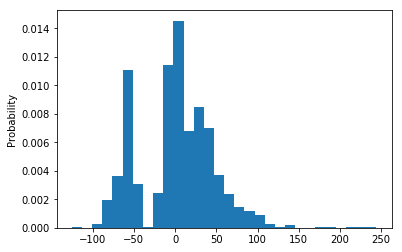

In [17]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#x = np.random.normal(size = 1000)
plt.hist(point, normed=True, bins=30)
plt.ylabel('Probability');